# **Recurrent Neural Network - Analyse de sentiments**

Le but de cet exercice est la classification binaire (positive ou négative) de reviews en utilisant un RNN sur un dataset de commentaires IMDB que vous trouverez dans le dossier data.

In [1]:
# import des librairies
import string
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

from sklearn.model_selection import train_test_split

## **1. Import des données et preprocessing**

1. Importer les 2 fichiers ".txt" de data/imdb
2. Vérifier ce qu'il y a dedans si c'est pas déjà fait...
3. Un peu de preprocessing de texte, allez on va chercher dans sa petite mémoire et sinon dans son gros ordinateur :
>- convertir en minuscules
>- retirer la ponctuation
>- créer une liste des reviews et déterminer combien il y en a. Pareil pour les labels. Inch'Allah y en aura autant.

In [2]:
# lire les ".txt"
with open('data/imdb/reviews.txt', 'r') as f:
    reviews_str = f.read()
with open('data/imdb/labels.txt', 'r') as f:
    labels_str = f.read()

In [3]:
# reviews
type(reviews_str), len(reviews_str), reviews_str[:100]

(str,
 33678267,
 'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life')

In [4]:
# labels
type(labels_str), len(labels_str), labels_str[:100]

(str,
 225000,
 'positive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nn')

In [5]:
# en minuscules
reviews_str = reviews_str.lower()

In [6]:
# sans ponctuation
reviews_str = reviews_str.translate(str.maketrans('', '', string.punctuation))

In [7]:
# split et nb de review
reviews = reviews_str.split('\n')
len(reviews)

25001

In [8]:
# split et nb de label
labels = labels_str.split('\n')
len(labels)

25001

## **2. Tokenisation ou encodage**

Le but est de remplacer les mots des reviews par des entiers. Si vous voulez faire à votre sauce, vous y êtes encouragés !

Sinon, les quelques étapes décrites ci-dessous vous permettront de le faire :
>- compter l'ensemble des mots (vous pouvez utiliser `Counter` de la librairie `collections` qui est une des plus rapide dans ce domaine)
>- les trier par ordre décroissant d'occurrences
>- créer un dictionnaire `word_mapping` où les clés sont les mots et les valeurs l'entier associé (votre dico doit être `{'the': 1, 'and': 2, 'a': 3, 'of': 4,..., 'muppified': 74070, 'whelk': 74071, 'hued': 74072}}`). C'est volontaire que ça commence à 1 car on utilisera le "0" comme caractère pour remplir les reviews les plus courtes afin qu'elles aient toutes la même taille...
>- encoder les mots (c'est-à-dire les remplacer par l'entier qui les représente)
>- encoder les labels (ça c'est fastoche, on se débrouille)

In [9]:
# comptage des mots et tri par occurrence
words = ' '.join(reviews).split()
word_count = Counter(words)
sorted_words = sorted(word_count, key=word_count.get, reverse=True)

In [10]:
# dictionnaire de correspondance mot = entier
word_mapping = {w:i+1 for i,w in enumerate(sorted_words)}

In [11]:
# encodage des mots
reviews_num = [list(map(lambda w: word_mapping[w], rvw.split())) for rvw in reviews]
print(reviews_num[:2])

[[21025, 308, 6, 3, 1050, 207, 8, 2138, 32, 1, 171, 57, 15, 49, 81, 5785, 44, 382, 110, 140, 15, 5194, 60, 154, 9, 1, 4975, 5852, 475, 71, 5, 260, 12, 21025, 308, 13, 1978, 6, 74, 2395, 5, 613, 73, 6, 5194, 1, 24103, 5, 1983, 10166, 1, 5786, 1499, 36, 51, 66, 204, 145, 67, 1199, 5194, 19869, 1, 37442, 4, 1, 221, 883, 31, 2988, 71, 4, 1, 5787, 10, 686, 2, 67, 1499, 54, 10, 216, 1, 383, 9, 62, 3, 1406, 3686, 783, 5, 3483, 180, 1, 382, 10, 1212, 13583, 32, 308, 3, 349, 341, 2913, 10, 143, 127, 5, 7690, 30, 4, 129, 5194, 1406, 2326, 5, 21025, 308, 10, 528, 12, 109, 1448, 4, 60, 543, 102, 12, 21025, 308, 6, 227, 4146, 48, 3, 2211, 12, 8, 215, 23], [63, 4, 3, 125, 36, 47, 7472, 1395, 16, 3, 4181, 505, 45, 17, 3, 622, 134, 12, 6, 3, 1279, 457, 4, 1721, 207, 3, 10624, 7373, 300, 6, 667, 83, 35, 2116, 1086, 2989, 34, 1, 898, 46417, 4, 8, 13, 5096, 464, 8, 2656, 1721, 1, 221, 57, 17, 58, 794, 1297, 832, 228, 8, 43, 98, 123, 1469, 59, 147, 38, 1, 963, 142, 29, 667, 123, 1, 13584, 410, 61, 94, 177

In [12]:
# encodage des labels
labels_num = [1*(label == 'positive') for label in labels]

## **3. Longueur des séquences**

Il s'agit ici d'analyser la longueur des reviews pour déterminer éventuellement des outliers et choisir ce qu'on en fait. On va aussi "uniformiser" la longueur des séquence.

1. Avec la méthode de votre choix (graphique, stats desc...), étudier la longueur des reviews
2. Déterminer s'il y a des outliers et ce que vous souhaitez en faire (si vous les décidez de les supprimer, attention de bien supprimer aussi les labels correspondants...)
3. Ça a été évoqué un peu plus haut, on veut que nos reviews aient toutes la même taille pour faciliter l'entraînement du réseau. Par conséquent on va ajouter des 0 aux reviews les plus courtes et tronquer les reviews les plus longues (*padding/truncating*, si vous vous souvenez bien on a vu il y a peu le *zero-padding* dans un certain cas...bon ben c'est pareil).  
>- définir une fonction `trunc_pad(review_list, length)` :
>>- qui prend en paramètres la liste des reviews (chaque review étant encodée en une liste d'entiers) et une longueur donnée
>>- et qui retourne un array 2D avec (en ligne) les reviews trop longues tronquées et des 0 à gauche pour les reviews trop courtes. Avant de vous lancer et pour vous assurer d'avoir compris, quelles dimensions doit avoir votre array en sortie ?
>>- tester votre fonction avec une longueur fixée à 250 et afficher les 5 premières valeurs des 5 premières reviews. Vous devez obtenir ça:  
\[[    0     0     0     0     0]  
[    0     0     0     0     0]  
[22382    42 46418    15   706]  
[ 4505   505    15     3  3342]  
[    0     0     0     0     0]\]
>- maintenant, que c'est fait, je peux vous le dire, il y a une fonction dans `keras.preprocessing` qui permet de le faire. La trouver et comparer les temps d'éxecution des 2 fonctions.

count    25001.000000
mean       240.798208
std        179.020628
min          0.000000
25%        130.000000
50%        179.000000
75%        293.000000
max       2514.000000
dtype: float64

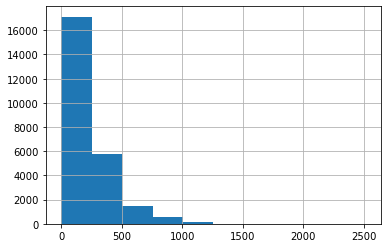

In [13]:
# la longueur des reviews
reviews_len = list(map(len, reviews_num))
pd.Series(reviews_len).hist();
pd.Series(reviews_len).describe()

In [14]:
# nombre de review de taille 0 : une seule
Counter(reviews_len)[0]

1

In [15]:
# suppression de la review de taille 0
idx0 = np.where(np.array(reviews_len)==0)[0][0]
del reviews_num[idx0]
del labels_num[idx0]

# autre méthode un peu plus lente
#reviews_num = [reviews_num[i] for i,l in enumerate(reviews_len) if l>0]
#labels_num = [labels_num[i] for i,l in enumerate(reviews_len) if l> 0]

In [16]:
# la fonction padding/truncating avec en sortie un array de taille (nombre_de_reviews, taille_fixée_des_séquences)
seq_len = 500 # la variable seq_len contient pour la suite la longueur fixée des séquences
def trunc_pad(review_list=reviews_num, length=seq_len):
    output = np.zeros((len(review_list), length), dtype = int)
    
    for i,rvw in enumerate(review_list):
        rvw_len = len(rvw)
        output[i,-rvw_len:] = np.array(rvw)[:length]
    
    return output

In [17]:
# test et affichage
print(trunc_pad(length=250)[:5,:5])

[[    0     0     0     0     0]
 [    0     0     0     0     0]
 [22382    42 46418    15   706]
 [ 4505   505    15     3  3342]
 [    0     0     0     0     0]]


In [18]:
%%time
X = pad_sequences(reviews_num, maxlen=seq_len)

CPU times: user 469 ms, sys: 29.8 ms, total: 498 ms
Wall time: 465 ms


In [19]:
%%time
X = trunc_pad(review_list=reviews_num, length=seq_len)

CPU times: user 410 ms, sys: 51.4 ms, total: 462 ms
Wall time: 460 ms


## **4. Échantillons d'entraînement, de validation et de test**

Découper les données en train, validation et test sets de la manière qui vous plaira. Tant que c'est juste et cohérent bien sûr.  
Il faut qu'il y ait 20000 observations dans le train, 2500 dans le validation et 2500 dans le test. 

In [20]:
y = np.array(labels_num)
X.shape, y.shape

((25000, 500), (25000,))

In [21]:
%%time
# méthode sklearn
X2, X_test, y2, y_test = train_test_split(X, y, test_size = 2500)
X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size = 2500)

CPU times: user 35.7 ms, sys: 15.9 ms, total: 51.6 ms
Wall time: 51.4 ms


In [22]:
%%time
# méthode "à la main" : on a 25000 observations, on en met 20000 dans le train, 2500 dans le validation et 2500 dans le test
# sans oublier d'introduire de l'aléatoire : pour ça on va shuffle les vecteurs X et y mais attention il faut les mélanger de la même manière...
idx_shuffled = np.arange(25000)
np.random.shuffle(idx_shuffled)
X_shuffled = X[idx_shuffled]
y_shuffled = y[idx_shuffled]

train_size = 20000
X_train, X2 = X_shuffled[:train_size], X_shuffled[train_size:]
y_train, y2 = y_shuffled[:train_size], y_shuffled[train_size:]

test_size = 2500
X_val, X_test = X2[:test_size], X2[test_size:]
y_val, y_test = y2[:test_size], y2[test_size:]

CPU times: user 15.8 ms, sys: 15.9 ms, total: 31.7 ms
Wall time: 30.2 ms


In [23]:
# on check les shapes
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(20000, 500) (2500, 500) (2500, 500)
(20000,) (2500,) (2500,)


## **5. Petite paranthèse sur le _word embedding_**

Le [*word embedding*](https://fr.wikipedia.org/wiki/Word_embedding) consiste à transformer des mots sous forme de vecteurs de nombres. Bon ça on peut le faire relativement facilement, vous venez d'ailleurs de le faire avec la représentation du lexique des reviews en nombres entiers. Pour passer à un vecteur il suffirait juste de faire un one-hot-encoding.

Il y a plusieurs problèmes à cette solution (même si on l'utilise parfois dans du NLP simple) :
- la dimension de l'espace engendré
- l'absence totale de notion de similarité (avec la représentation one-hot, 2 mots qui n'ont rien à voir sont aussi différents que 2 mots tout à fait synonyme)
- le fait que les vecteurs contiennent quasiment que des 0 (sparse matrix)

Donc le *word embedding* s'attaque à ce problème avec pour objectifs de :
1. représenter les mots sous forme de vecteurs de nombres réels (et non entiers, on passe donc à un espace continu et plus discret)
2. conserver la notion de similarité c'est-à-dire que 2 vecteurs qui sont proches doivent représenter des mots "sémantiquement proches"
3. de les représenter dans un espace de plus petite dimension (en fonction de votre vocabulaire, soit le nombre de mots dans votre problème, ça peut aller très vite, généralement plusieurs milliers ou 10aines de milliers)

Le principe est de s'intéresser au contexte des mots, c'est-à-dire, quels mots sont associés ensemble en s'appuyant sur la co-occurrence.
Différents modèles de word embedding existent : [word2vec](https://fr.wikipedia.org/wiki/Word2vec), 

En pratique avec `keras`, que se passe-t-il lorsqu'on ajout une couche [*embedding*](https://keras.io/api/layers/core_layers/embedding/) ? Un exemple juste en dessous.

Un peu de visionnage pour y voir plus clair si ça vous intéresse :
- https://www.youtube.com/watch?v=Eku_pbZ3-Mw
- https://www.youtube.com/watch?v=oUpuABKoElw
- https://www.youtube.com/watch?v=5PL0TmQhItY

Et un peu de lecture :
- https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
- https://towardsdatascience.com/why-do-we-use-embeddings-in-nlp-2f20e1b632d2
- https://towardsdatascience.com/word-embeddings-for-nlp-5b72991e01d4
- https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf
- https://medium.com/rasa-blog/supervised-word-vectors-from-scratch-in-rasa-nlu-6daf794efcd8
- https://web.stanford.edu/~jurafsky/slp3/6.pdf

In [24]:
# on prend quelques phrases
t1 = "i hope to see you again"
t2 = "you wish to see me soon"
t3 = "i wish we will meet again"

In [25]:
# si on reprend en gros nos étapes de preprocessing
cnts = Counter(t1.split() + t2.split() + t3.split())
dico = {w:i for i,w in enumerate(sorted(cnts, key=cnts.get, reverse=True))}
dico, len(dico)

({'i': 0,
  'to': 1,
  'see': 2,
  'you': 3,
  'again': 4,
  'wish': 5,
  'hope': 6,
  'me': 7,
  'soon': 8,
  'we': 9,
  'will': 10,
  'meet': 11},
 12)

In [26]:
# et donc on peut les représenter comme ça
t1_int = [dico[w] for w in t1.split()]
t2_int = [dico[w] for w in t2.split()]
t3_int = [dico[w] for w in t3.split()]
t1_int, t2_int, t3_int

([0, 6, 1, 2, 3, 4], [3, 5, 1, 2, 7, 8], [0, 5, 9, 10, 11, 4])

In [27]:
# on crée un modèle avec une couche embedding
# input_dim : taille du vocabulaire = nombre de mots dans le lexique, ici c'est 9
# output_dim : taille des vecteurs utilisée pour représenter les mots, ici 2 car on a que 9 mots mais on choisit souvent 32/64 selon la taille du vocabulaire
# input_length : taille des séquences d'input, ici c'est 6
model_emb = Sequential()
model_emb.add(Embedding(input_dim=12, output_dim=2, input_length=6))

model_emb.compile('rmsprop', 'mse')
out1 = model_emb.predict([t1_int]) # les crochets pour ajouter une dimension car le modèle est entraîné sur des inputs à 2 dimensions
out2 = model_emb.predict([t2_int])
out3 = model_emb.predict([t3_int])
out1, out2, out3

(array([[[-0.02313391, -0.00737948],
         [ 0.01848278, -0.01095483],
         [ 0.0044451 ,  0.00905938],
         [ 0.03042718, -0.01061307],
         [ 0.0430409 , -0.00418841],
         [-0.01192189,  0.02178173]]], dtype=float32),
 array([[[ 0.0430409 , -0.00418841],
         [-0.01960553,  0.03789306],
         [ 0.0044451 ,  0.00905938],
         [ 0.03042718, -0.01061307],
         [ 0.03431991,  0.02336348],
         [-0.03446075,  0.03879006]]], dtype=float32),
 array([[[-0.02313391, -0.00737948],
         [-0.01960553,  0.03789306],
         [-0.02391529,  0.00860884],
         [ 0.02560779,  0.00216025],
         [ 0.02318671, -0.02602875],
         [-0.01192189,  0.02178173]]], dtype=float32))

## **6. Création, entraînement et évaluation du modèle**

Créer un premier modèle, que vous serez tout à fait libre et même cordialement conviés à améliorer par la suite, avec :
- une couche Embedding
- une couche LSTM

In [28]:
model=Sequential()

model.add(Embedding(input_dim=len(word_mapping)+1, output_dim=64, input_length=seq_len))
model.add(LSTM(units=100))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           4740672   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               66000     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 4,806,773
Trainable params: 4,806,773
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=3)

Epoch 1/3
625/625 [==============================] - 668s 1s/step - loss: 0.4631 - accuracy: 0.7829 - val_loss: 0.3629 - val_accuracy: 0.8464
Epoch 2/3
625/625 [==============================] - 615s 985ms/step - loss: 0.2630 - accuracy: 0.8992 - val_loss: 0.3006 - val_accuracy: 0.8768
Epoch 3/3
625/625 [==============================] - 632s 1s/step - loss: 0.1466 - accuracy: 0.9488 - val_loss: 0.3395 - val_accuracy: 0.8720


In [31]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy:', scores[1])

Accuracy: 0.8668000102043152
